In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH_DATA = '/workspace/data'

In [5]:
df_unidade_1 = pd.read_csv(f'{BASE_PATH_DATA}/movimentos_unidade_1.csv')
df_unidade_2 = pd.read_csv(f'{BASE_PATH_DATA}/movimentos_unidade_2.csv')


with open(f'{BASE_PATH_DATA}/cnj-movimentos-tree.json', 'r') as f:
    cnj_tree = json.load(f)

In [6]:
# 1. Limpeza e Filtragem dos Dados

# Exibir o número de movimentos antes da remoção
print(f'Unidade 1 Antes de Remover: {df_unidade_1.shape[0]} movimentos')
print(f'Unidade 2 Antes de Remover: {df_unidade_2.shape[0]} movimentos')

# Criar cópias dos dataframes originais
df_unidade_1_copy = df_unidade_1.copy()
df_unidade_2_copy = df_unidade_2.copy()

# Definir os movimentos insignificantes
movimentos_insignificantes = ['Publicação', 'Decurso de Prazo', 'Mero Expediente']

# Remover espaços em branco e converter para minúsculas
df_unidade_1_copy['activity'] = df_unidade_1_copy['activity'].str.strip().str.lower()
df_unidade_2_copy['activity'] = df_unidade_2_copy['activity'].str.strip().str.lower()

# Converter a lista de movimentos insignificantes para minúsculas
movimentos_insignificantes = [movimento.lower() for movimento in movimentos_insignificantes]

# 2. Remover os movimentos insignificantes das cópias dos dataframes
df_unidade_1_copy = df_unidade_1_copy[~df_unidade_1_copy['activity'].isin(movimentos_insignificantes)]
df_unidade_2_copy = df_unidade_2_copy[~df_unidade_2_copy['activity'].isin(movimentos_insignificantes)]

# Exibir o número de movimentos depois da remoção
print(f'Unidade 1 Depois de Remover: {df_unidade_1_copy.shape[0]} movimentos')
print(f'Unidade 2 Depois de Remover: {df_unidade_2_copy.shape[0]} movimentos')

Unidade 1 Antes de Remover: 243768 movimentos
Unidade 2 Antes de Remover: 239001 movimentos


Unidade 1 Depois de Remover: 230444 movimentos
Unidade 2 Depois de Remover: 221367 movimentos


In [7]:
# 3. Agrupamento dos Movimentos com Base na Árvore do CNJ
# Usar a estrutura da árvore CNJ para criar categorias de movimentos
def agrupar_movimentos(movimento_id, cnj_tree):
    movimento_id = str(movimento_id)
    
    def buscar_grupo(node, movimento_id, path=[]):
        if movimento_id in node:
            return path + [movimento_id]
        
        for key, sub_node in node.items():
            result = buscar_grupo(sub_node, movimento_id, path + [key])
            if result:
                return result
        return None
    
    grupo = buscar_grupo(cnj_tree, movimento_id)
    return " > ".join(grupo) if grupo else 'Outros'


df_unidade_1_copy['grupo_movimento'] = df_unidade_1_copy['movimentoID'].apply(lambda x: agrupar_movimentos(x, cnj_tree))
df_unidade_2_copy['grupo_movimento'] = df_unidade_2_copy['movimentoID'].apply(lambda x: agrupar_movimentos(x, cnj_tree))

print("Agrupamento CNJ 1",df_unidade_1_copy.head())
print("Agrupamento CNJ 2",df_unidade_2_copy.head())


Agrupamento CNJ 1                          NPU  processoID                activity  \
0  0052885-00.2022.0.00.0000   186510447            distribuição   
1  0052885-00.2022.0.00.0000   186510447               audiência   
2  0052885-00.2022.0.00.0000   186510447               audiência   
3  0052885-00.2022.0.00.0000   186510447  expedição de documento   
4  0052230-00.2022.0.00.0000   186919890  expedição de documento   

                      dataInicio                      dataFinal  duration  \
0  2022-10-24T23:46:31.769726000  2022-10-24T23:46:31.769726000         0   
1  2022-10-24T23:46:31.769726000  2022-10-24T23:46:32.593726000         0   
2  2022-12-14T12:58:53.104726000  2022-12-14T17:22:17.040726000     15803   
3  2022-12-14T17:22:17.040726000  2022-12-14T17:23:34.820726000        77   
4  2022-10-21T17:40:19.013726000  2022-11-18T04:30:16.725726000   2371797   

                                   classe                         assunto  \
0  Procedimento do Juizado Especi

In [8]:
# 4. Especialização dos Movimentos
def especializar_movimentos(row):
    complemento = row['complemento'] if isinstance(row['complemento'], str) else 'N/A'
    documento = row['documento'] if isinstance(row['documento'], str) else 'N/A'
    
    if row['movimentoID'] == 85:
        return "Petição - " + complemento if complemento != 'N/A' else "Petição"
    elif row['movimentoID'] == 60:
        return "Expedição de Documento - " + documento if documento != 'N/A' else "Expedição de Documento"
    # Adicionar outros critérios aqui conforme necessário
    else:
        return row['activity']  # Ou outra lógica

df_unidade_1_copy['atividade_especializada'] = df_unidade_1_copy.apply(especializar_movimentos, axis=1)
df_unidade_2_copy['atividade_especializada'] = df_unidade_2_copy.apply(especializar_movimentos, axis=1)

print("Especialização Movimentos 1", df_unidade_1_copy.head())
print("Especialização Movimentos 2", df_unidade_2_copy.head())

Especialização Movimentos 1                          NPU  processoID                activity  \
0  0052885-00.2022.0.00.0000   186510447            distribuição   
1  0052885-00.2022.0.00.0000   186510447               audiência   
2  0052885-00.2022.0.00.0000   186510447               audiência   
3  0052885-00.2022.0.00.0000   186510447  expedição de documento   
4  0052230-00.2022.0.00.0000   186919890  expedição de documento   

                      dataInicio                      dataFinal  duration  \
0  2022-10-24T23:46:31.769726000  2022-10-24T23:46:31.769726000         0   
1  2022-10-24T23:46:31.769726000  2022-10-24T23:46:32.593726000         0   
2  2022-12-14T12:58:53.104726000  2022-12-14T17:22:17.040726000     15803   
3  2022-12-14T17:22:17.040726000  2022-12-14T17:23:34.820726000        77   
4  2022-10-21T17:40:19.013726000  2022-11-18T04:30:16.725726000   2371797   

                                   classe                         assunto  \
0  Procedimento do Juiz

In [9]:
# 5. Análise Descritiva
# Estatísticas básicas
print("Estatísticas Descritivas - Unidade 1")
print(df_unidade_1_copy[['processoID', 'duration', 'movimentoID', 'grupo_movimento', 'atividade_especializada']].describe())

print("\nEstatísticas Descritivas - Unidade 2")
print(df_unidade_2_copy[['processoID', 'duration', 'movimentoID', 'grupo_movimento', 'atividade_especializada']].describe())

# Frequência de grupos de movimentos
print("\nFrequência de Grupos de Movimentos - Unidade 1")
print(df_unidade_1_copy['grupo_movimento'].value_counts())

print("\nFrequência de Grupos de Movimentos - Unidade 2")
print(df_unidade_2_copy['grupo_movimento'].value_counts())


Estatísticas Descritivas - Unidade 1
         processoID      duration    movimentoID
count  2.304440e+05  2.304440e+05  230444.000000
mean   4.664292e+07  1.116717e+06     523.139249
std    6.760273e+07  5.281407e+06    1697.503303
min    2.271550e+07  0.000000e+00      22.000000
25%    2.428452e+07  9.500000e+01      60.000000
50%    2.531247e+07  7.134850e+04      85.000000
75%    2.833661e+07  6.354828e+05     466.000000
max    3.959683e+08  3.118170e+08   14739.000000

Estatísticas Descritivas - Unidade 2


         processoID      duration    movimentoID
count  2.213670e+05  2.213670e+05  221367.000000
mean   3.778941e+07  1.675361e+06     438.637435
std    5.016154e+07  5.583786e+06    1414.077672
min    2.271688e+07  0.000000e+00      22.000000
25%    2.484999e+07  2.300000e+01      60.000000
50%    2.546802e+07  4.971700e+04      85.000000
75%    2.871458e+07  1.032256e+06     466.000000
max    3.988678e+08  2.396737e+08   15216.000000

Frequência de Grupos de Movimentos - Unidade 1
grupo_movimento
14 > 48 > 60                 54370
14 > 48 > 67 > 85            49531
14 > 48 > 51                 29960
14 > 48 > 970                27106
14 > 48 > 861 > 246          14066
                             ...  
1 > 3 > 968 > 334                1
1 > 3 > 11 > 12151               1
1 > 3 > 25 > 960                 1
1 > 11009 > 11025 > 11012        1
1 > 3 > 7 > 821                  1
Name: count, Length: 96, dtype: int64

Frequência de Grupos de Movimentos - Unidade 2
grupo_movimento
14 > 48 

In [10]:
# 1. Análise de Grupos Específicos

# Identificar os 5 grupos de movimentos mais frequentes na Unidade 1
top_grupos_unidade_1 = df_unidade_1_copy['grupo_movimento'].value_counts().head(5)
print("Top 5 Grupos de Movimentos - Unidade 1:")
print(top_grupos_unidade_1)

# Calcular estatísticas descritivas para esses grupos
for grupo in top_grupos_unidade_1.index:
    print(f"\nEstatísticas Descritivas para o Grupo {grupo} - Unidade 1")
    print(df_unidade_1_copy[df_unidade_1_copy['grupo_movimento'] == grupo]['duration'].describe())


# Identificar os 5 grupos de movimentos mais frequentes na Unidade 2
top_grupos_unidade_2 = df_unidade_2_copy['grupo_movimento'].value_counts().head(5)
print("Top 5 Grupos de Movimentos - Unidade 2:")
print(top_grupos_unidade_2)

# Calcular estatísticas descritivas para esses grupos
for grupo in top_grupos_unidade_2.index:
    print(f"\nEstatísticas Descritivas para o Grupo {grupo} - Unidade 2")
    print(df_unidade_2_copy[df_unidade_2_copy['grupo_movimento'] == grupo]['duration'].describe())

Top 5 Grupos de Movimentos - Unidade 1:
grupo_movimento
14 > 48 > 60           54370
14 > 48 > 67 > 85      49531
14 > 48 > 51           29960
14 > 48 > 970          27106
14 > 48 > 861 > 246    14066
Name: count, dtype: int64

Estatísticas Descritivas para o Grupo 14 > 48 > 60 - Unidade 1
count    5.437000e+04
mean     6.306298e+05
std      3.308898e+06
min      0.000000e+00
25%      2.930000e+02
50%      7.104500e+04
75%      3.339815e+05
max      2.670688e+08
Name: duration, dtype: float64

Estatísticas Descritivas para o Grupo 14 > 48 > 67 > 85 - Unidade 1
count    4.953100e+04
mean     2.538207e+06
std      8.330071e+06
min      0.000000e+00
25%      9.429450e+04
50%      7.548760e+05
75%      2.089036e+06
max      2.415061e+08
Name: duration, dtype: float64

Estatísticas Descritivas para o Grupo 14 > 48 > 51 - Unidade 1
count    2.996000e+04
mean     5.492853e+05
std      2.753870e+06
min      0.000000e+00
25%      1.400000e+01
50%      1.820000e+02
75%      7.724700e+04
max     


Média de Duração do Grupo 14 > 48 > 60 - Comparação Entre Unidades
Unidade 1: 630629.7568879897
Unidade 2: 1016132.6887282132

Média de Duração do Grupo 14 > 48 > 67 > 85 - Comparação Entre Unidades
Unidade 1: 2538207.410227938
Unidade 2: 2652542.919443073

Média de Duração do Grupo 14 > 48 > 51 - Comparação Entre Unidades
Unidade 1: 549285.2639853137
Unidade 2: 833319.0141127614

Média de Duração do Grupo 14 > 48 > 970 - Comparação Entre Unidades
Unidade 1: 597595.2877222755
Unidade 2: 999920.1260491019

Média de Duração do Grupo 14 > 48 > 861 > 246 - Comparação Entre Unidades
Unidade 1: 184197.54265605006
Unidade 2: 1197547.1765877958


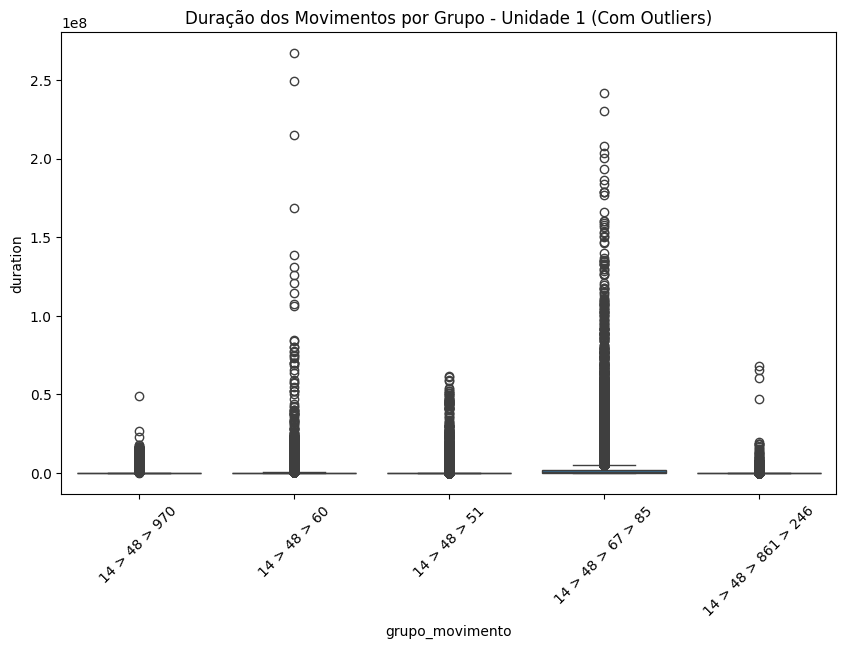

In [12]:
# 3. Comparação Entre Unidades

# Comparar a média de duração dos movimentos entre as unidades
media_duracao_grupos_1 = df_unidade_1_copy.groupby('grupo_movimento')['duration'].mean()
media_duracao_grupos_2 = df_unidade_2_copy.groupby('grupo_movimento')['duration'].mean()

# Exibir comparação de médias para os top 5 grupos
for grupo in top_grupos_unidade_1.index:
    print(f"\nMédia de Duração do Grupo {grupo} - Comparação Entre Unidades")
    print(f"Unidade 1: {media_duracao_grupos_1.get(grupo, np.nan)}")
    print(f"Unidade 2: {media_duracao_grupos_2.get(grupo, np.nan)}")

# Visualização dos Outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='grupo_movimento', y='duration', data=df_unidade_1_copy[df_unidade_1_copy['grupo_movimento'].isin(top_grupos_unidade_1.index)])
plt.title("Duração dos Movimentos por Grupo - Unidade 1 (Com Outliers)")
plt.xticks(rotation=45)
plt.show()